### ***Pre-requisites***

Installing necessary packages for our analysis

In [1]:
!pip install emoji --quiet
!pip install --upgrade emoji --quiet
!pip install plotly --quiet
!pip install pandas nltk --quiet
!pip install wordcloud --quiet
!pip install vaderSentiment --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


Importing required libraries

In [2]:
import regex
import plotly.express as px
import pandas as pd
import numpy as np
import emoji
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import holoviews as hv

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('nps_chat')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.


True

### ***Project Description***  

***WhatsApp Chat Visualizer***  

  A sophisticated tool meticulously crafted for the purpose of rendering comprehensive analyses and graphical representations of your WhatsApp group or individual chat dialogues. This Python-based application endeavors to transcend raw chat data, affording users a nuanced comprehension of communication patterns, participant engagement, and the overarching dynamics inherent within their conversations.

**Outline**

This project is divided into 3 parts:
1. Exploratory data analysis
    *   Visualisations
    *   Emoji analysis
2. Sentiment Analysis
3. Naive Bayes' Classification


**Data Source**

WhatsApp allows users to export chat histories from individual or group chats. I have exported chat (excluding media) of my college group named, 'CU Boulder Fall Admissions 2023'. Since, this group has members from various countries, most of the conversations will be in English, which is my first requirement to go ahead.

Here is how one can export chat from Whatsapp -
1. Open the WhatsApp chat you want to export.
2. Tap on the contact or group name at the top to open the contact/group info screen.
3. Scroll down and look for the "Export Chat" option. The wording may vary slightly depending on your device (e.g., "Export Chat" or "Email Chat").
4. Select the option and choose whether to include media files (images, videos) or not.
5. Choose the email app or method to share the exported chat.

**Data Description**

This group has 539 members and is the main platform to communicate all events like workshops, seminars, celebrations, discussing new things. When we export chat in .txt file, the output will be in standard format with date, time, author and message, but needs slight formatting to convert to a dataframe.  

The raw file looks like this :   

9/12/23, 19:29 - +1 (303) 523-4576: Oh i’m here  
9/12/23, 19:30 - +1 (720) 335-2889: I'm outside

**Data Preparation**

I have defined some formatting functions to prepare the data before importing. These functions are designed to parse and extract information from strings representing messages with a specific date-time format. The `date_time` function checks if a string follows a specific date-time pattern, the `find_author` function checks for the presence of an author in a message, and the `getDatapoint` function extracts date, time, author, and message from a given line.

In [20]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message


Mounting google drive to read files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing files**

The .txt file is read into `conversation` variable and formatting is carried out for easy analysis.

In [21]:
data = []
conversation = '/content/drive/MyDrive/Whatsapp Analysis/WhatsApp Chat with CU Boulder - Fall 2023.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [22]:
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])

**Respecting Privacy**

I have masked the real names/numbers of authors to protect their privacy. I have replaced all members in group and with dummy names.

In [28]:
contacts_list_full = pd.read_excel("/content/drive/MyDrive/Whatsapp Analysis/Contacts_list_full.xlsx")
merged_df = pd.merge(df, contacts_list_full, on='Author', how='left')

merged_df['Author'] = merged_df['Name_Author'].combine_first(merged_df['Author'])
merged_df = merged_df.drop(columns=['Name_Author'])
df = merged_df

This is how our dataframe looks like.

In [27]:
df.head()

,Date,Time,Author,Message
0,2023-01-09,03:25,None,"+91 6302 062 413 created group ""CU Boulder Fal..."
1,2023-09-12,17:39,You joined a group via invite in the community,CU Boulder Fall 2023
2,2023-09-12,17:39,None,Amulya CUB joined from the community
3,2023-09-12,18:39,Person-1,?
4,2023-09-12,19:29,Person-2,Oh i’m here


In [30]:
# Checking for null values

df.isna().sum()

Date         0
Time         0
Author     126
Message      0
dtype: int64

**Data Cleaning**

*Handling Null values*

The column `author` has 126 null values. When author is None, it means that message is not originally a chat, but an action performed in group like adding someone to group/creation of group/removing someone/inviting. So, we can drop such kind of rows.

But I have joined this group on 12th September. The first row can also be dropped. I have kept it to show the start date of chat.

In [97]:
df = df.dropna()
df.head()

,Date,Time,Author,Message
1,2023-09-12,17:39,You joined a group via invite in the community,CU Boulder Fall 2023
3,2023-09-12,18:39,Person-1,?
4,2023-09-12,19:29,Person-2,Oh i’m here
5,2023-09-12,19:30,Person-1,I'm outside
6,2023-09-12,19:30,Person-1,<Media omitted>


### ***Part-1: Exploratory Data Analysis***


Now, let's see basic descriptive analysis with following statistics of entire chat to get a grip on:

1. **Time Span**: From start date to end date
2. **Media**: Total number of media shared in group
3. **Top contributors**: Who messaged most
4. **Busiest**: A tale of our most active day
5. **Averages**: words per message, letters per message, messages per day
6. **Pulse of Expression**: Frequency analysis of emojis
7. **Chatterbox**: Where Words Never Take a Shortcut
8. **Micro Maestro**: The Short-Message Sorcerer
9. **Time Series analysis**: Distribution across the day

**Time Span**: From start date to end date

In [98]:
# 1. Time Span

start_date, end_date = df.sort_values(['Date','Time']).agg({'Date': ['min', 'max']}).reset_index()['Date']
Chat_span_period = end_date-start_date
print(f'Chats starting from {start_date.strftime("%A")} {start_date.strftime("%b")} {start_date.day}th {start_date.year} until {end_date.strftime("%A")} {end_date.strftime("%b")} {end_date.day}th {end_date.year}')
print(f'For what duration did the conversation persist? {Chat_span_period}')

Chats starting from Tuesday Sep 12th 2023 until Monday Dec 25th 2023
For what duration did the conversation persist? 104 days 00:00:00



**Media**: Total number of media shared in group

In [99]:
# 2. Total number of media shared in group

df[df['Message']=='<Media omitted>'].agg({'Message':'count'})

Message    117
dtype: int64

Data Cleaning

1. While exporting chat from whatsapp, I have excluded media. So, the rows with Message showing as, "\<Media omitted>" can be dropped from our dataset

2. There are some messages shown as "This message was deleted", "joined", "via invite". These rows can also be dropped.

3. Created a new datafarme `df_filtered` by eliminating all these unnecessary rows with a clean dataset



In [127]:
eliminate = ['This message was deleted', '<Media omitted>']

df_filtered = df[~df['Message'].isin(eliminate)]

df_filtered = df_filtered[~df_filtered['Message'].str.contains('joined using this group\'s invite link')]
df_filtered = df_filtered[~df_filtered['Author'].str.contains('via invite')]
df_filtered.head()

,Date,Time,Author,Message
3,2023-09-12,18:39,Person-1,?
4,2023-09-12,19:29,Person-2,Oh i’m here
5,2023-09-12,19:30,Person-1,I'm outside
7,2023-09-12,20:02,Person-2,good.
10,2023-09-12,20:28,Person-3,I won the PingPong tournament.


**Top contributors**: Who messaged most

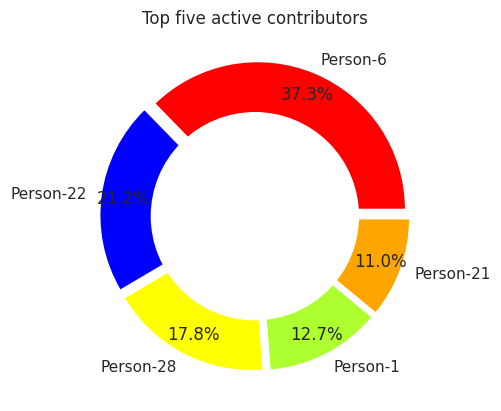

In [107]:
# 3. Top 5 active members of group
top_5 = df_filtered.groupby('Author').agg({'Message': 'count'}).reset_index().sort_values('Message', ascending=False).head()

# Let's add a small visualisation

sizes = top_5['Message']

labels = top_5['Author']
colors = ['#FF0000', '#0000FF', '#FFFF00', '#ADFF2F',
		'#FFA500']
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

# Pie Chart
plt.pie(sizes, colors=colors, labels=labels,
		autopct='%1.1f%%', pctdistance=0.85,
		explode=explode)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

fig.gca().add_artist(centre_circle)

plt.title('Top five active contributors')

plt.show()


**Busiest Day**: The most active day in a week & overall




In [133]:
# 4. Busiest Day (In a week)

day_list = []
for date_ in df_filtered['Date']:
  day_list.append(datetime.strftime(date_, '%A'))

df_filtered['Day_of_date']= day_list

day_wise = df_filtered.groupby(['Date', 'Day_of_date']).agg({'Message':'count'}).reset_index().sort_values('Message', ascending=False)
day_wise_freq = day_wise.groupby('Day_of_date').agg({'Message':'mean'}).reset_index()
day_wise_freq.style.highlight_max(color='orange')

,Day_of_date,Message
0,Friday,6.583333
1,Monday,4.692308
2,Saturday,4.538462
3,Sunday,5.636364
4,Thursday,6.500000
5,Tuesday,5.142857
6,Wednesday,8.000000


In [71]:
fig = px.line_polar(day_wise_freq, r='Message', theta='Day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(title='Average number of messages per day', title_x=0.5)
fig.show()
# fig.write_image('https://github.com/SnehaSasanapuri/WhatsApp_Chat_Analysis/blob/main/Polar_plot.png')

From above graph, we can see that frequency is highest for Wednesday and lowest for Saturday in a week.

In [137]:
# 4. Busiest Day (Overall)


d3b = df_filtered.groupby('Date').agg({'Message':'count'}).reset_index().sort_values('Message', ascending=False).head(1)
print(f"Most active day of chat: {datetime.strftime(d3b.iloc[0,0], '%A')} {datetime.strftime(d3b.iloc[0,0], '%b')} {d3b.iloc[0,0].day}th, {d3b.iloc[0,0].year}")


Most active day of chat: Wednesday Sep 27th, 2023


In [73]:
lengths_ = []
for message in df_filtered['Message']:
  lengths_.append(len(message))

df_filtered['length of message']=lengths_
df_filtered.tail()

group_ = df_filtered.groupby('Author').agg({'length of message' : ['mean', 'count']})
group_.reset_index(inplace=True)

**Averages**: words per message, letters per message, messages per day

In [74]:
# 5. Averages a.Words count/message b.Messages count/day  c.Letters count/message

words_count = []
for message in df_filtered['Message']:
  words_count.append(message.count(' ')+1)
df_filtered['words_count']=words_count
df_filtered['letters_count'] = np.where(df_filtered['words_count'] > 1,
                                        df_filtered['length of message'] - df_filtered['words_count'] - 1,
                                        df_filtered['length of message'])
avg_counts_day = df_filtered.agg({'words_count':'mean', 'letters_count':'mean'}).reset_index()
message_count_day = df_filtered.groupby('Date').agg({'Message':'count'}).reset_index().agg({'Message':'mean'})
print(f'Average no.of words per message is {round(avg_counts_day.iloc[0,1])} \nAverage no.of letters per message is {round(avg_counts_day.iloc[1,1])} \nAverage no.of messages per day is {round(message_count_day[0])}')

Average no.of words per message is 16 
Average no.of letters per message is 75 
Average no.of messages per day is 6


In [75]:
emoji_list_ = []
for message in df_filtered['Message']:
  if emoji.emoji_count(message) > 0:
    emoji_list_.append(emoji.emoji_list(message))
#print(emoji_list_)

empty_list = []
for emoj in emoji_list_:
  for i in range(len(emoj)):
    if emoj[i]['emoji']:
      empty_list.append(emoj[i]['emoji'])
# print (empty_list)


Certain emojis are not getting rendered. There are several issues associated with this:

1. Skin tone customisation : \U0001faf1🏼, \U0001faf2🏼
2. Combination of base emojis : 😶\u200d🌫️ - Combo of Face Without Mouth & Fog
3. Rendering limitations : \U0001f979, \U0001fae8

For these five cases, we can use simply `print()` function to render output correctly.

In [76]:
from collections import Counter

# Count the occurrences of each emoji
emoji_frequencies = Counter(empty_list)

sorted_dict = dict(sorted(emoji_frequencies.items(), key=lambda item: item[1], reverse=True))
# print(sorted_dict)

**Pulse of Expression**: Frequency analysis of emojis

In [77]:
# Extract emojis and frequencies
emojis, frequencies = zip(*emoji_frequencies.items())

df_emojis = pd.DataFrame({'Emoji': emojis, 'Frequency': frequencies})
df_emojis = df_emojis[df_emojis['Frequency']>1]

fig = px.bar(df_emojis, x='Emoji', y='Frequency', text='Frequency', color='Frequency',
             labels={'Frequency': 'Frequency Count'},
             title='Emoji Frequencies')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.update_xaxes(type='category')

fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()
# fig.write_image('https://github.com/SnehaSasanapuri/WhatsApp_Chat_Analysis/blob/main/emoji_plot.png')


**Chatterboxes & Micro writers**

Now, let's see who is preferring lengthy messages and who is a short message replier.

In [110]:
# Top 5 people with lengthy messages
group_.sort_values(by=('length of message', 'mean')).tail(n=5).style.background_gradient(axis='index')


Let's see what are these lengthy messages about!

In [79]:
authors_list_lengthy = list(group_.sort_values(by=('length of message', 'mean')).tail(n=5)['Author'])
pd.set_option('display.max_colwidth', None)
# for i in range(len(authors_list_lengthy)):
#   print(df_filtered[df_filtered['Author'] == authors_list_lengthy[i]]['Message'])

In [120]:
# Top 5 people with shortest messages
group_.sort_values(by=('length of message', 'mean')).head(n=5).style.background_gradient(axis='index')

In [81]:
authors_list_shortest = list(group_.sort_values(by=('length of message', 'mean')).head(n=5)['Author'])

# Let's see these shortest messages

pd.set_option('display.max_colwidth', None)
for i in range(len(authors_list_shortest)):
  print(df_filtered[df_filtered['Author'] == authors_list_shortest[i]]['Message'])

140    ✋
Name: Message, dtype: object
127    😂😂😂
Name: Message, dtype: object
436    Weekend
Name: Message, dtype: object
644    @17205797578
Name: Message, dtype: object
554    Happy Diwali🎊
Name: Message, dtype: object


From these two things, we can observe that -

1. Most of the lengthy messages are about housing/leasing/sale/Invitation mentioning some event

2. Most of the shortest messages are about greeting/congratulating

**Time Series analysis**

Distribution of message counts across different times of a day in week

In [82]:
pal = sns.cubehelix_palette(7, rot=-.25, light=.7)
days_freq = list(df_filtered['Day_of_date'].value_counts().index)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lst = list(zip(days, pal[::-1]))
# lst

In [83]:
pal_reorder=[]

for i in days:
    #print(i)
    j=0
    for day in days_freq:

        if i == day:
            #print(lst[j][1])
            pal_reorder.append(lst[j][1])
        j+=1
# pal_reorder

In [84]:
df_filtered['parsed_time'] = pd.to_datetime(df_filtered['Time'], format="%H:%M").dt.time

In [85]:
hrs_ = []
for time_ in df_filtered['Time']:
  hrs_.append(int(time_.split(":")[0]))

df_filtered['float_time_hrs']=hrs_

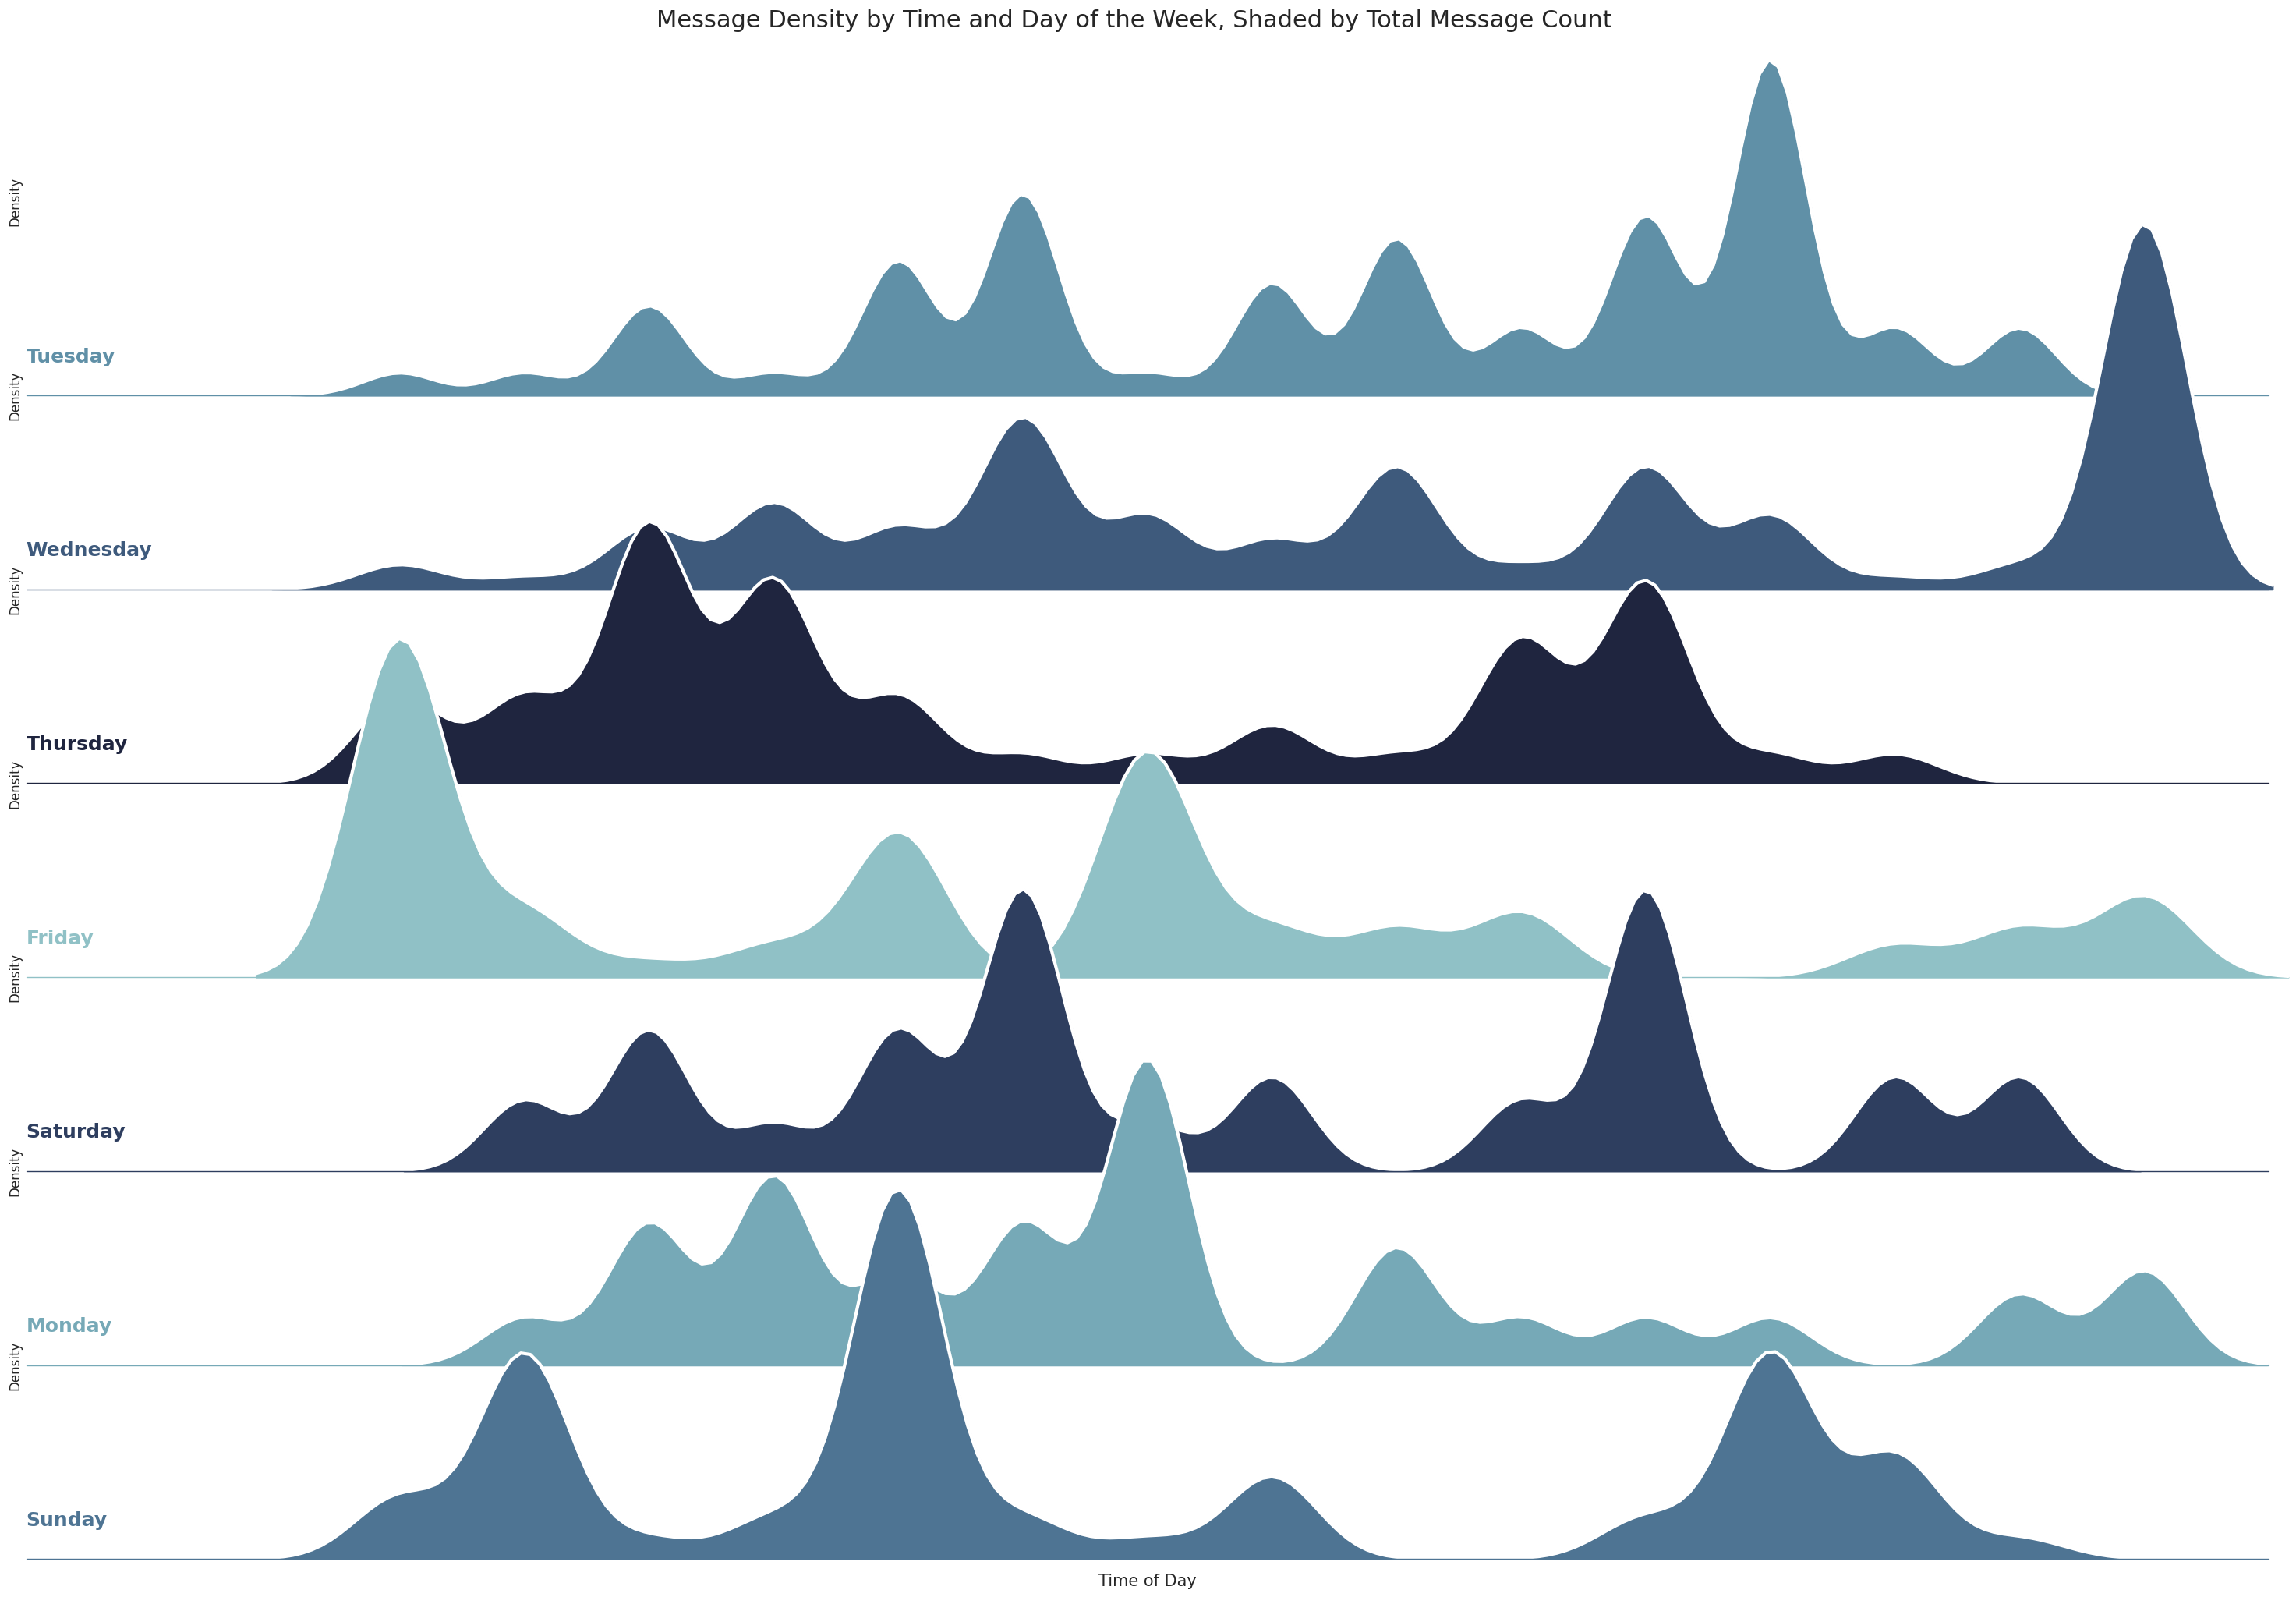

In [86]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(7, rot=-.25, light=.7)
g = sns.FacetGrid(df_filtered[df_filtered['float_time_hrs'] > 8], row="Day_of_date", hue="Day_of_date", aspect=10, palette=pal_reorder, xlim=(7,24))

# Draw the densities in a few steps
g.map(sns.kdeplot, "float_time_hrs", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.2)
g.map(sns.kdeplot, "float_time_hrs", clip_on=False, color="w", lw=3, bw_adjust=.2)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, size=18)

g.map(label, 'float_time_hrs')
g.set_xlabels('Time of Day', fontsize=15)
g.set_xticklabels(fontsize=20)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.5)
g.fig.suptitle('Message Density by Time and Day of the Week, Shaded by Total Message Count', fontsize=22)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

### ***Part-2: Sentiment Analysis***



I have carried out sentiment analysis of messages using `VADER` library. **VADER (Valence Aware Dictionary and sEntiment Reasoner)** provides a compound sentiment score, which represents the overall sentiment of the text. The compound score can be interpreted as follows:

1. Positive sentiment: Compound score >= 0.05
2. Neutral sentiment: -0.05 < Compound score < 0.05
3. Negative sentiment: Compound score <= -0.05  

VADER is particularly useful for analyzing sentiment in short texts, social media posts, and informal language. Ituses a combination of-

A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. It not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

In [124]:
compound_scores = []
sid_obj = SentimentIntensityAnalyzer()
for message in df_filtered['Message']:
  compound_scores.append(sid_obj.polarity_scores(message)['compound'])

df_filtered['Sentiment_score']=compound_scores

df_filtered['Overall_sentiment']=np.where(df_filtered['Sentiment_score']>= 0.05, 'Positive',
                                          np.where((df_filtered['Sentiment_score'] >= -0.05) & (df_filtered['Sentiment_score'] < 0.05),
                                                     'Neutral',
                                                     'Negative'))

df_filtered.head().style.background_gradient(axis='index')

,Date,Time,Author,Message,Sentiment_score,Overall_sentiment
3,2023-09-12 00:00:00,18:39,Person-1,?,0.000000,Neutral
4,2023-09-12 00:00:00,19:29,Person-2,Oh i’m here,0.000000,Neutral
5,2023-09-12 00:00:00,19:30,Person-1,I'm outside,0.000000,Neutral
7,2023-09-12 00:00:00,20:02,Person-2,good.,0.440400,Positive
10,2023-09-12 00:00:00,20:28,Person-3,I won the PingPong tournament.,0.571900,Positive


The in-built function `SentimentIntensityAnalyzer()` outputs three scores in dictionary format `{'neg':-xx, 'neu':xx, 'pos':xx, 'compound':xx}`. Each word in the text is assigned a polarity score, ranging from -1 (most negative) to 1 (most positive). The scores are normalised and then aggregated to get the overall polarity score for the text which is nothing but compound score.  


**Word Cloud**

I have removed punctuation and stop words to identify key theme of the chat messages

In [88]:
df_filtered['tokenized_message'] = df_filtered['Message'].apply(lambda x: word_tokenize(str(x)))

In [89]:
concatenated_values = []

for message in df_filtered['tokenized_message']:
  for i in range(len(message)):
    concatenated_values.append(message[i])

# Remove punctuation
tokens_without_punctuation = [word for word in concatenated_values if word.isalnum()]

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens_without_punctuation if word.lower() not in stop_words]

# Join the filtered tokens into a cleaned text
cleaned_text = ' '.join(filtered_tokens)

# print("Original Text:")
# print(concatenated_values)
# print("\nCleaned Text:")
# print(cleaned_text)

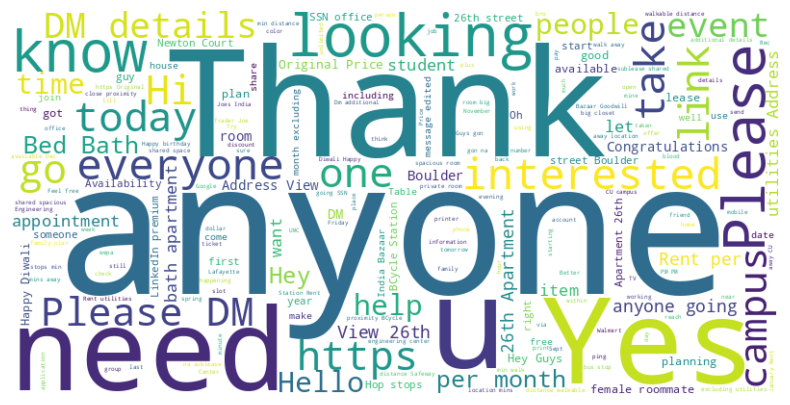

In [90]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

**Sentiment variation over day**

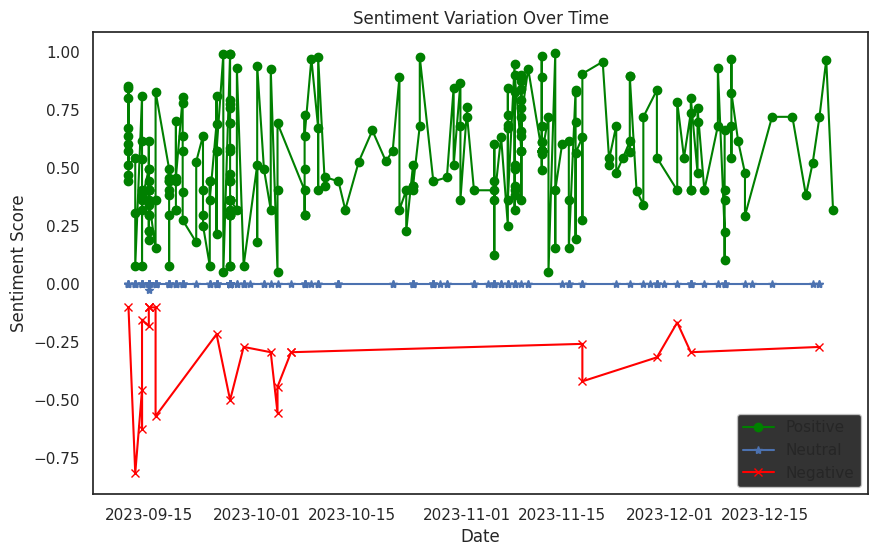

In [91]:
positive_data = df_filtered[df_filtered['Overall_sentiment'] == 'Positive']
neutral_data = df_filtered[df_filtered['Overall_sentiment'] == 'Neutral']
negative_data = df_filtered[df_filtered['Overall_sentiment'] == 'Negative']

plt.figure(figsize=(10, 6))

plt.plot(positive_data['Date'], positive_data['Sentiment_score'], label='Positive', marker='o', color='green')
plt.plot(neutral_data['Date'], neutral_data['Sentiment_score'], label='Neutral', marker='*')
plt.plot(negative_data['Date'], negative_data['Sentiment_score'], label='Negative', marker='x', color='red')

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Variation Over Time')
plt.legend()
plt.show()

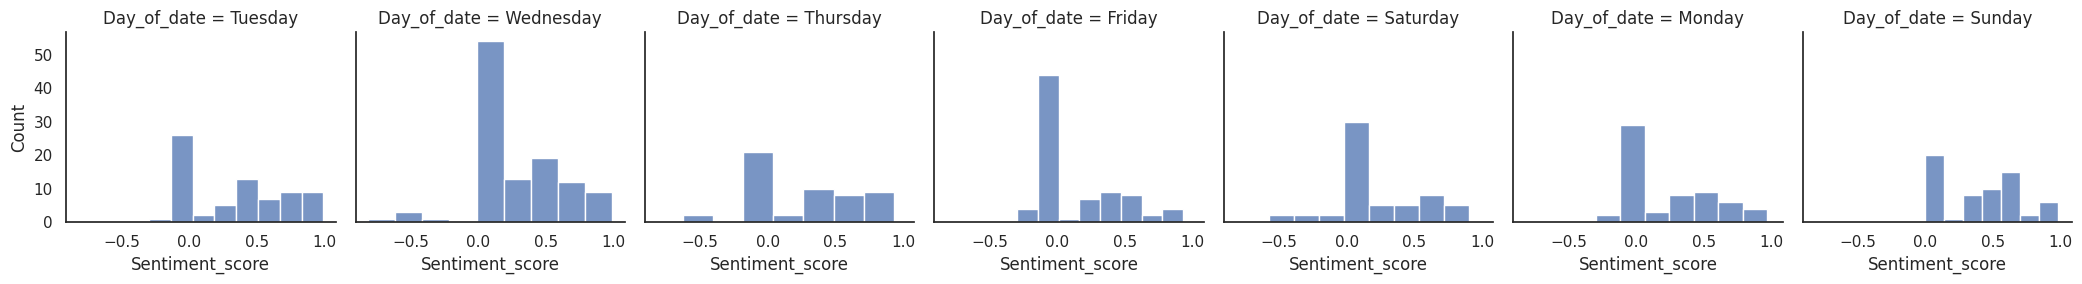

In [92]:
g = sns.FacetGrid(df_filtered, col='Day_of_date')
g.map(sns.histplot, "Sentiment_score")

### ***Part-3: Naive Bayes Classification***

We are using the Natural Language Toolkit (nltk) to build a simple text classifier. Each posts from the NPS Chat dataset is associated with a particular class. The `extract_features` function tokenizes each post into words and creates a set of features indicating whether each word is present in the post. These features are then used to train our Naive Bayes classifier.   

The dataset is split into a training set and a test set, and the classifier is trained using the training set. The resulting classifier can predict the class of new messages based on the words they contain.

In [93]:
posts = nltk.corpus.nps_chat.xml_posts()

def extract_features(post):
    features = {}
    for word in nltk.word_tokenize(post):
        features['contains({})'.format(word.lower())] = True
    return features

fposts = [(extract_features(p.text), p.get('class')) for p in posts]
test_size = int(len(fposts) * 0.1)
train_set, test_set = fposts[test_size:], fposts[:test_size]
classifier = nltk.NaiveBayesClassifier.train(train_set)


In [94]:
category_ = []
for message in df_filtered['Message']:
  category_.append(classifier.classify(extract_features(message)))

df_filtered['Category']=category_

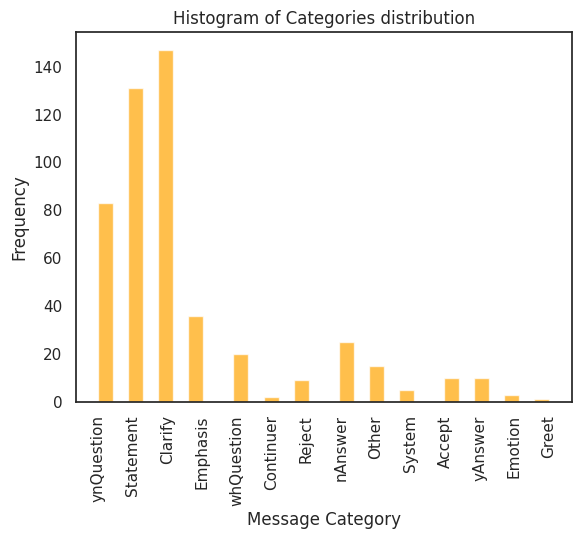

In [95]:
plt.hist(df_filtered['Category'], bins=30, color='orange', alpha=0.7)

plt.title('Histogram of Categories distribution')
plt.xlabel('Message Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

**Sankey Flow diagram**

It’s a useful plot of how the messages are getting fragmented into various categories — something like a stream which splits into sub branches as it moves along. It is a very usual and intuitive visual to tell us how the flow is structured.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
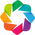

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.



:Sankey   [source_name,target_name]   (value)

In [96]:
hv.extension('bokeh')
edges = pd.read_excel('/content/drive/MyDrive/Whatsapp Analysis/Sanky_input.xlsx')
sankey = hv.Sankey(edges, label='A Breakout of WhatsApp group messages by Category')
sankey.opts(label_position='right', edge_color='target_name', node_color='index', cmap='tab20')
# fig.write_image('https://github.com/SnehaSasanapuri/WhatsApp_Chat_Analysis/blob/main/bokeh_plot.png')


**References**

https://www.flerlagetwins.com/2019/09/text-analysis.html?m=1  

https://towardsdatascience.com/advanced-visualisations-for-text-data-analysis-fc8add8796e2

https://thecleverprogrammer.com/2021/04/09/whatsapp-chat-analysis-with-python/  

https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a  

https://www.ijraset.com/research-paper/whatsapp-data-sentiment-analyzer  

https://www.youtube.com/watch?v=7yAw1nPareM  



### ***Part-4: Findings***

1. The chats analysed in this code spanned from **`Tuesday Sep 12th 2023`** to **`Monday Dec 25th 2023`** and conversation persisted for **`104 days`**  

2. The total number of media messages shared in group is **`117`**

3. **`Persons-1, 6, 21, 22, 28`** are the most active members of the group  who contribute the highest amount of content  

4. Users were most engaged on **`Wednesdays`**, making it the busiest day in terms of chat interactions  

5. A day that truly stole the spotlight - **`September 27th, 2023`** turned out to be the chat's superstar  

6. On average, messages are like little tales, weaving about **`16 words`** and **`75 letters per message`** into each conversation  

7. The daily exchange rate of messages is an average of **`6 messages`**, providing insights into the frequency and flow of communication over time  

8. The top three emojis that added a sprinkle of emotion to these conversations are **`😂`** with **`13 appearances`**, followed by **`🪔`** lighting up our chat **`8 times`**, and **`🥳`** joining the celebration **`7 times`**. Seems like laughter, festive lights, and celebrations have carved their special place in emoji landscape  

9. Lengthier messages often revolve around **`housing, leasing, sales, or invitations`**, with detailed discussions about upcoming events. On the flip side, our shortest messages are typically **`greetings or congratulations`**  

10. In time series analysis, it's fascinating to see how conversations ebb and flow. Looking at the days of the week, **`Mondays`** are a bit quiet with fewer messages. But when **`Thursday`** rolls around, that's when the chat is buzzing the most  

11. In the word cloud, common words like **`Thank`**, **`Please`**, **`anyone`**, **`need`**, **`yes`** and **`looking`** stand out. It hints at a polite and helpful vibe in chat room, creating a friendly and cooperative atmosphere  

12. The graph of sentiment variation over time showcases a **`dominance of positive texts`**, highlighting the upbeat and optimistic nature of our conversations over the course of the day  

13. In employing Naive Bayes classification to categorize texts, a discernible pattern emerged. The top three classifications are: **`Yes/No questions`**, **`Clarification questions`** and **`Statements`**. This classification breakdown sheds light on the predominant nature of text content, revealing a mix of inquiry, clarification, and straightforward statements within conversations